# Air Quality Analysis

In [14]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## 1. Data Loading and Preprocessing

In [15]:
# Load data
df = pd.read_csv("data.csv")
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")


# Function to categorize air quality
def categorize_air_quality(value):
    if 0 <= value <= 50:
        return "Good"
    elif 51 <= value <= 100:
        return "Moderate"
    elif 101 <= value <= 150:
        return "Unhealthy for Sensitive"
    elif 151 <= value <= 200:
        return "Unhealthy"
    elif 201 <= value <= 400:
        return "Hazardous"
    else:
        return "Unknown"


# Create categorical labels
df["air_quality_category"] = df["Air Quality"].apply(categorize_air_quality)

# Display class distribution
print("\nClass distribution:")
print(df["air_quality_category"].value_counts())

# Filter out classes with less than 2 samples
min_samples = 2
class_dist = df["air_quality_category"].value_counts()
valid_classes = class_dist[class_dist >= min_samples].index
df_filtered = df[df["air_quality_category"].isin(valid_classes)]

print(f"\nFiltered data shape: {df_filtered.shape}")
print("\nNew class distribution:")
print(df_filtered["air_quality_category"].value_counts())

Data loaded: 589876 rows, 11 columns

Class distribution:
air_quality_category
Moderate                   255994
Unhealthy                  174047
Unhealthy for Sensitive     89972
Good                        43768
Hazardous                   26095
Name: count, dtype: int64

Filtered data shape: (589876, 12)

New class distribution:
air_quality_category
Moderate                   255994
Unhealthy                  174047
Unhealthy for Sensitive     89972
Good                        43768
Hazardous                   26095
Name: count, dtype: int64


### Data Preprocessing

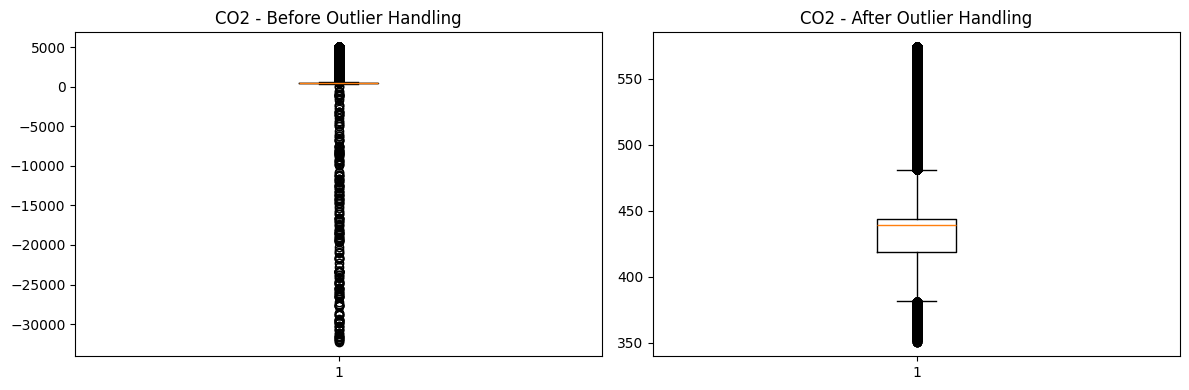

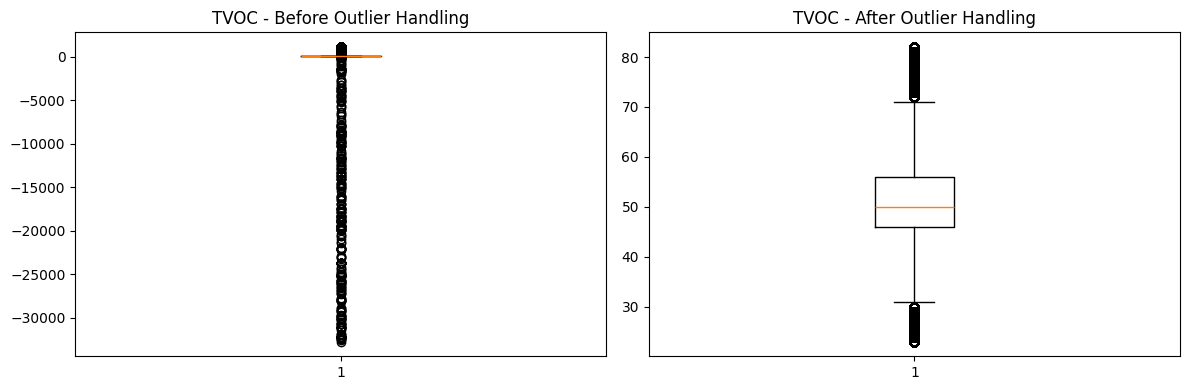

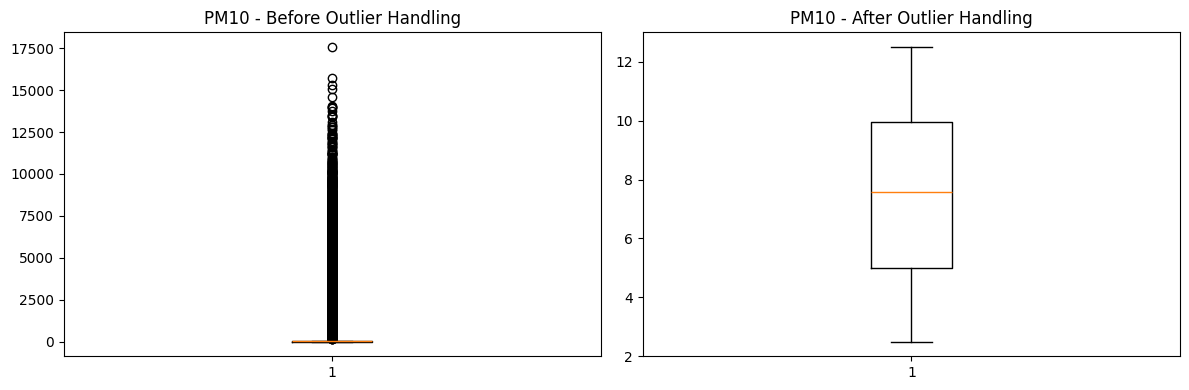

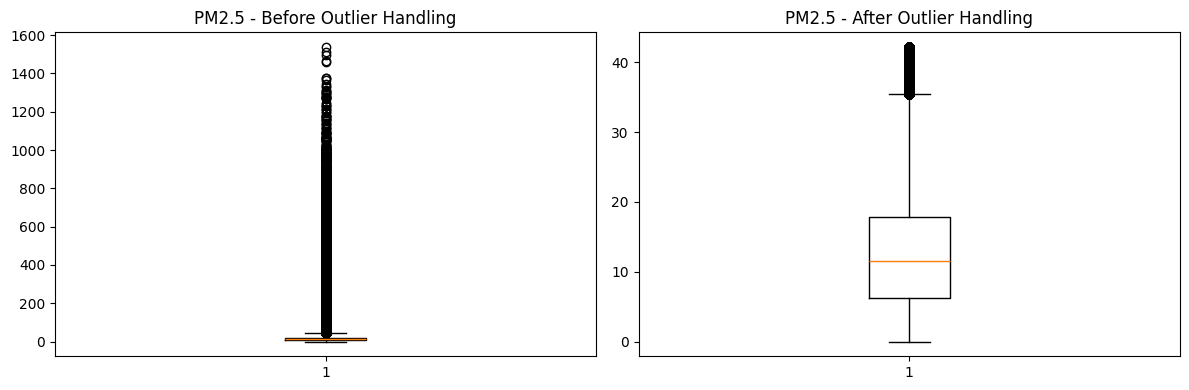

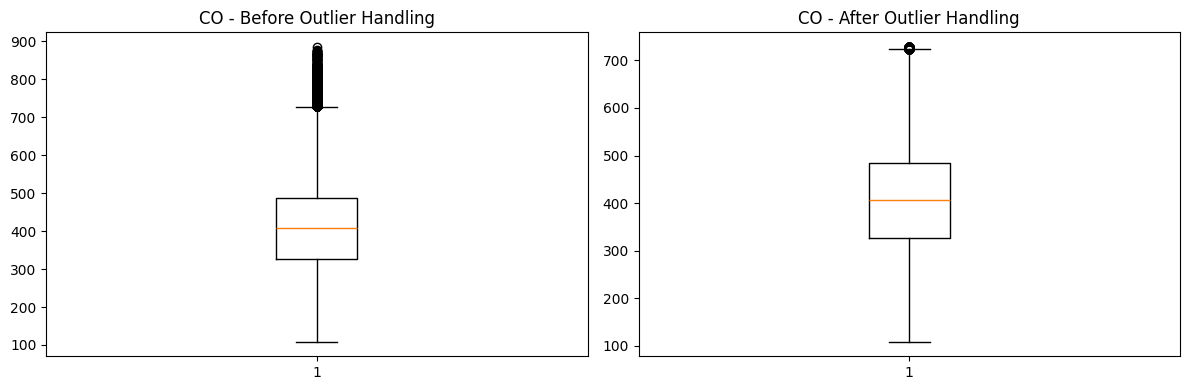

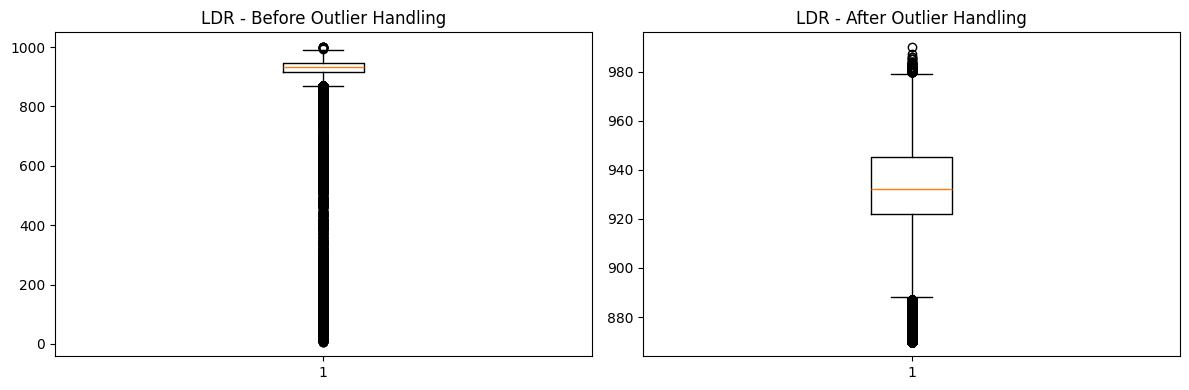

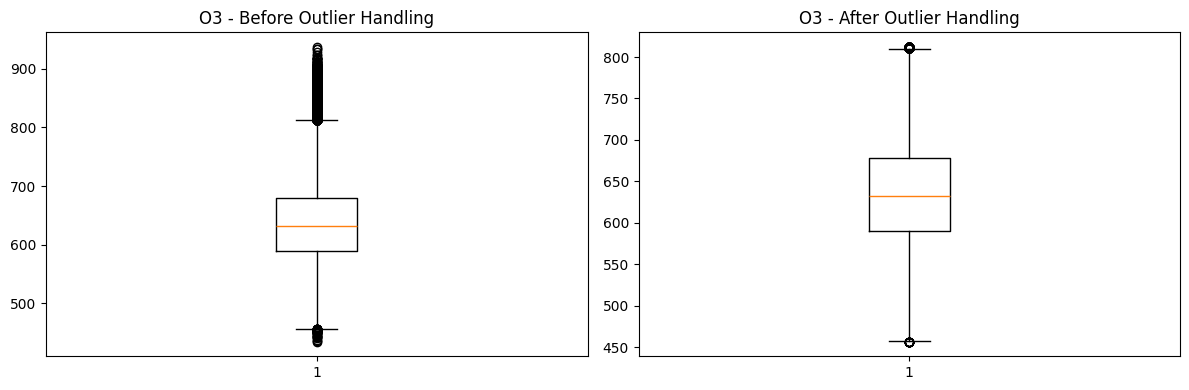

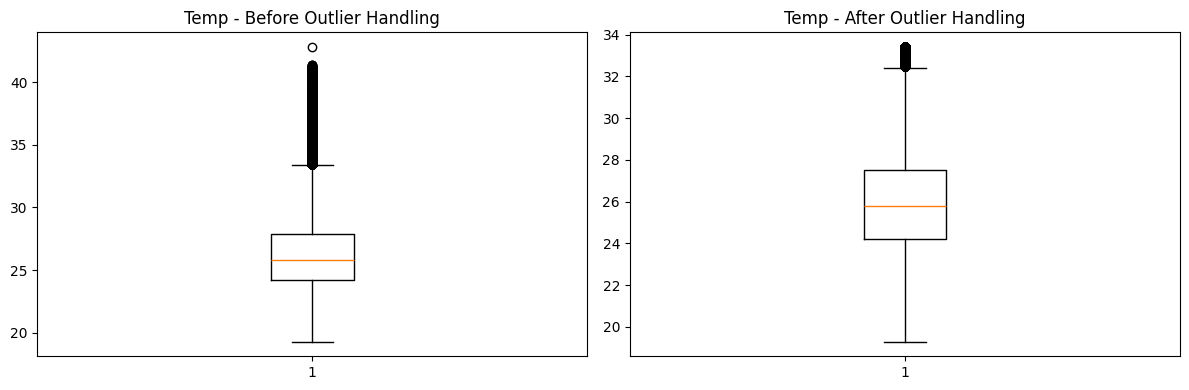

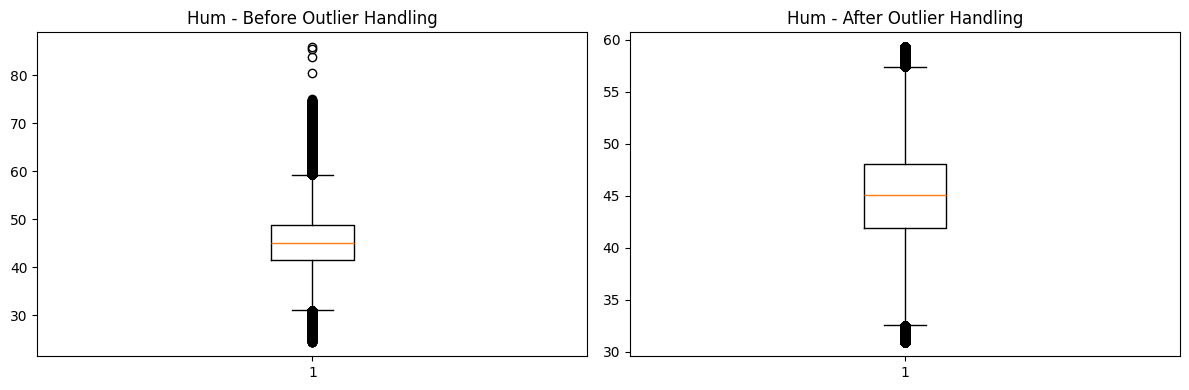


Class distribution after SMOTE:
3    204795
2    204795
4    204795
0    204795
1    204795
Name: count, dtype: int64


In [16]:
# Handle outliers using IQR method and replace with median
def handle_outliers(df, columns):
    df_clean = df.copy()

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median_val = df[col].median()

        # Plot before outlier handling
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.boxplot(df[col])
        plt.title(f"{col} - Before Outlier Handling")

        # Replace outliers with median
        df_clean.loc[df_clean[col] < lower_bound, col] = median_val
        df_clean.loc[df_clean[col] > upper_bound, col] = median_val

        # Plot after outlier handling
        plt.subplot(1, 2, 2)
        plt.boxplot(df_clean[col])
        plt.title(f"{col} - After Outlier Handling")
        plt.tight_layout()
        plt.show()

    return df_clean


# Define features for the models
features = ["CO2", "TVOC", "PM10", "PM2.5", "CO", "LDR", "O3", "Temp", "Hum"]
X = df_filtered[features].copy()

# Handle outliers
X = handle_outliers(X, features)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepare classification target
le = LabelEncoder()
y = le.fit_transform(df_filtered["air_quality_category"])

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Reshape data for deep learning models
X_train_reshaped = X_train_balanced.reshape(
    (X_train_balanced.shape[0], X_train_balanced.shape[1], 1)
)
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## 2. Model Definitions

In [17]:
num_features = len(features)
num_classes = len(np.unique(y))


def create_1dcnn():
    model = Sequential(
        [
            Conv1D(128, 2, activation="relu", input_shape=(num_features, 1)),
            Conv1D(64, 2, activation="relu"),
            Conv1D(32, 2, activation="relu"),
            Flatten(),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(num_classes, activation="softmax"),
        ]
    )
    return model


def create_rnn():
    model = Sequential(
        [
            tf.keras.layers.SimpleRNN(128, input_shape=(num_features, 1)),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(num_classes, activation="softmax"),
        ]
    )
    return model


def create_dnn():
    model = Sequential(
        [
            Flatten(input_shape=(num_features, 1)),
            Dense(256, activation="relu"),
            Dense(128, activation="relu"),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(num_classes, activation="softmax"),
        ]
    )
    return model


def create_lstm():
    model = Sequential(
        [
            LSTM(128, input_shape=(num_features, 1)),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(num_classes, activation="softmax"),
        ]
    )
    return model


def create_bilstm():
    model = Sequential(
        [
            Bidirectional(LSTM(128), input_shape=(num_features, 1)),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(num_classes, activation="softmax"),
        ]
    )
    return model

## 3. Model Training and Evaluation

In [ ]:
# Clear any previous models
tf.keras.backend.clear_session()

# Prepare models
models = {
    '1DCNN': create_1dcnn(),
    'RNN': create_rnn(),
    'DNN': create_dnn(),
    'LSTM': create_lstm(),
    'BiLSTM': create_bilstm()
}

results = {}
BATCH_SIZE = 128

for name, model in models.items():
    print(f"\nTraining {name}...")
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    # Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.0001
    )
    
    # Train model
    history = model.fit(
        X_train_reshaped,
        y_train_balanced,
        validation_split=0.2,
        epochs=50,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Evaluate
    y_pred = np.argmax(model.predict(X_test_reshaped, batch_size=BATCH_SIZE), axis=1)
    
    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'history': history.history,
        'model': model,
        'predictions': y_pred
    }
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Clear session for next model
    tf.keras.backend.clear_session()

## 4. Model Optimization

In [18]:
def optimize_and_save_model(model, model_name):
    """Optimize and save model with proper TFLite conversion settings."""
    print(f"\nOptimizing {model_name}...")

    # Save original model
    os.makedirs("models", exist_ok=True)
    model_path = f"models/{model_name}.h5"
    model.save(model_path)

    # Configure TFLite converter
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Enable experimental features for tensor list ops
    converter.experimental_enable_resource_variables = True
    converter._experimental_lower_tensor_list_ops = False

    # Set optimization options
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS,
    ]

    # Convert model
    try:
        quantized_model = converter.convert()

        # Save quantized model
        quantized_path = f"models/{model_name}_quantized.tflite"
        with open(quantized_path, "wb") as f:
            f.write(quantized_model)

        # Print size comparison
        original_size = os.path.getsize(model_path) / 1024  # KB
        quantized_size = os.path.getsize(quantized_path) / 1024  # KB

        print(f"\nModel Size Comparison:")
        print(f"Original: {original_size:.2f} KB")
        print(f"Quantized: {quantized_size:.2f} KB")
        print(
            f"Size reduction: {((original_size - quantized_size) / original_size * 100):.2f}%"
        )

        return True, quantized_path

    except Exception as e:
        print(f"\nError during model optimization: {str(e)}")
        print("Falling back to original model only")
        return False, model_path


# Get best performing model
best_model_name = max(results.items(), key=lambda x: x[1]["accuracy"])[0]
best_model = results[best_model_name]["model"]
print(f"Best performing model: {best_model_name}")

# Optimize and save the model
success, model_path = optimize_and_save_model(
    best_model, f"best_model_{best_model_name}"
)

if success:
    print(f"\nOptimized model saved to: {model_path}")
else:
    print(f"\nOriginal model saved to: {model_path}")

Best performing model: BiLSTM

Optimizing best_model_BiLSTM...
INFO:tensorflow:Assets written to: C:\WINDOWS\TEMP\tmpy1f2ixp2\assets


INFO:tensorflow:Assets written to: C:\WINDOWS\TEMP\tmpy1f2ixp2\assets


Saved artifact at 'C:\WINDOWS\TEMP\tmpy1f2ixp2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 9, 1), dtype=tf.float32, name='keras_tensor_49')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2293241145168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2293241146128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2293241146896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2293241142672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2293241147472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2293241148048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2293241145936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2293241148624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2293241149200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2293241147664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2293241149776: TensorSpec(s

## 5. Results Visualization

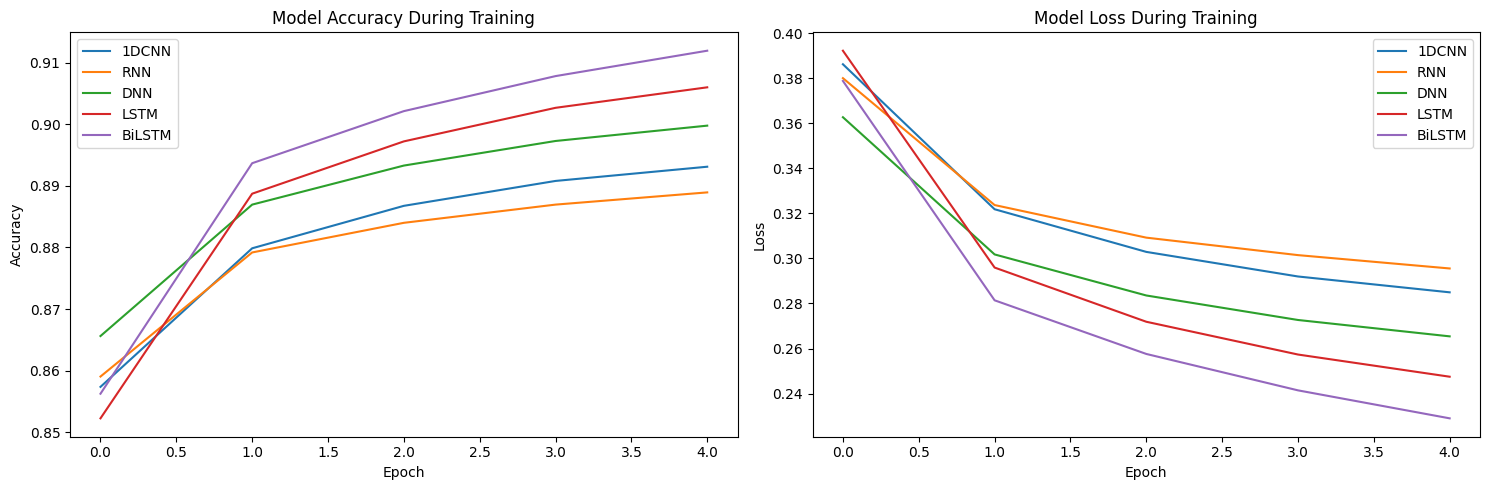

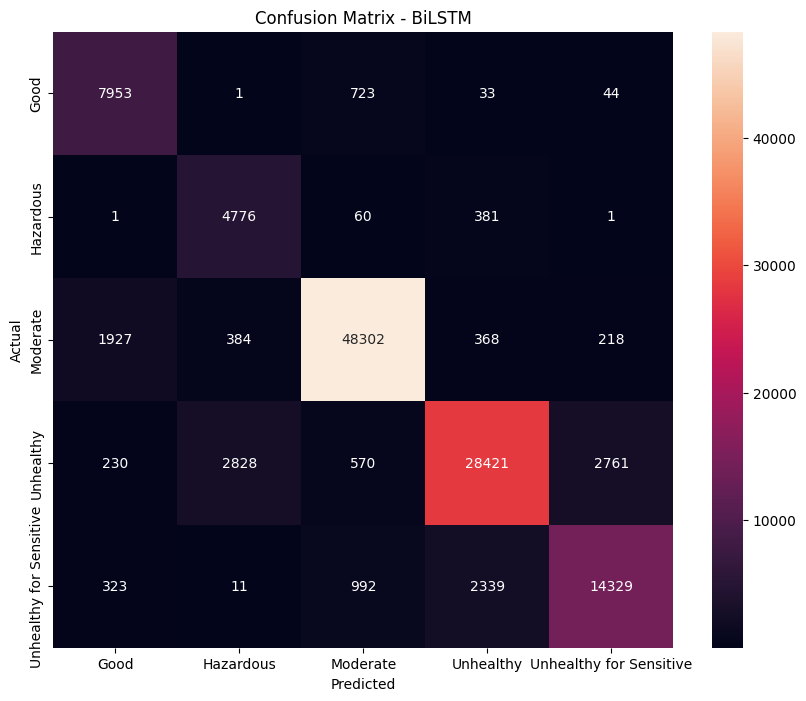

In [19]:
# Plot training history for all models
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for name in results:
    plt.plot(results[name]["history"]["accuracy"], label=f"{name}")
plt.title("Model Accuracy During Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
for name in results:
    plt.plot(results[name]["history"]["loss"], label=f"{name}")
plt.title("Model Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrix for best model
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, results[best_model_name]["predictions"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()